<h1><center><u>Thermal Expansion</u></center></h1>
<h1>1. <u>Introduction</u></h1>
<ul>
<li>A given crystal should have a well defined average lattice constant at a given pressure and temperature. Here we use silicon as an example to show how to calculate lattice constants using <code>GPUMD</code>.</li> 
</ul>

<h3>Importing Relevant Functions</h3>
<ul>
<li>The inputs/outputs for GPUMD are processed using the <a href="https://wiki.fysik.dtu.dk/ase/">Atomic Simulation Environment (ASE)</a> and the <a href="https://github.com/AlexGabourie/thermo">thermo</a> package.</li>
</ul>

In [1]:
from pylab import *
from ase.lattice.cubic import Diamond
from thermo.gpumd.io import ase_atoms_to_gpumd
from thermo.gpumd.data import load_thermo

<h1>2. <u>Preparing the Inputs</u></h1>
<ul>
    <li>We use a cubic system (of diamond structure) consisting of $10^3\times 8 = 8000$ silicon atoms and use the minimal Tersoff potential <a href="https://doi.org/10.1088/1361-648X/ab5c5f">[Fan 2020]</a>.</ul>
</ul>
<h2>Generate the <a href="https://gpumd.zheyongfan.org/index.php/The_xyz.in_input_file">xyz.in</a> file:</h2>

In [2]:
Si = Diamond('Si', size=(10,10,10))
Si

Lattice(symbols='Si8000', pbc=True, cell=[54.3, 54.3, 54.3])

In [3]:
ase_atoms_to_gpumd(Si, M=4, cutoff=3)

<ul>
<li>The first few lines of the <a href="https://gpumd.zheyongfan.org/index.php/The_xyz.in_input_file">xyz.in</a> file are:</li>
</ul>
<samp>
8000 4 3 0 0 0
1 1 1 54.3 54.3 54.3
0 0 0 0 28
0 0 2.715 2.715 28
0 2.715 0 2.715 28
0 2.715 2.715 0 28
</samp>

<ul>
<li>Explanations for the first line:</li>
   <ul>
     <li>The first number states that the number of particles is 8000.</li>
     <li>The second number in this line, 4, is good for silicon crystals described by the Tersoff potential because no atom can have more than 4 neighbor atoms in the temperature range studied. Making this number larger only results in more memory usage. If this number is not large enough, <code>GPUMD</code> will give an error message and exit.</li>
     <li>The next number, 3, means the initial cutoff distance for the neighbor list construction is 3 $\mathring A$. Here, we only need to consider the first nearest neighbors. Any number larger than the first nearest neighbor distance and smaller than the second nearest neighbor distance is OK here. Note that we will also not update the neighbor list. There is no such need in this problem.</li>
     <li>The remaining three zeros in the first line mean:</li>
         <ul>
             <li>the box is orthogonal;</li>
             <li>the initial velocities are not contained in this file; </li>
             <li>there is no grouping method defined here.</li>
         </ul>
    </ul>
<br>    
<li>Explanations for the second line:</li>
    <ul>
        <li>The first three 1's mean that all three directions are periodic. </li>
 <li>The remaining three numbers are the box lengths in the three directions. It can be seen that we have used an initial lattice constant of 5.43 $\mathring A$ to build the model.</li>
    </ul>
<br>    
<li>Starting from the third line, the numbers in the first column are all 0 here, which means that all the atoms are of type 0 (single atom-type system). The next three columns are the initial coordinates of the atoms. The last column gives the masses of the atoms. Here, we show isotopically pure Si-28 crystal, but this Jupyter notebook will generate an <a href="https://gpumd.zheyongfan.org/index.php/The_xyz.in_input_file">xyz.in</a> file using the average of the various isotopes of Si. In some applications, one can consider mass disorder in a flexible way.</li>
</ul>

<h2>The <code>run.in</code> file:</h2>
The <code>run.in</code> input file is given below:<br>
<samp>
potential   potentials/tersoff/Si_Fan_2019.txt 0
velocity    100

ensemble    npt_ber 100 100 0.01 0 0 0 0.0005
time_step   1
dump_thermo 10
run         20000

ensemble    npt_ber 200 200 0.01 0 0 0 0.0005
dump_thermo 10
run         20000

ensemble    npt_ber 300 300 0.01 0 0 0 0.0005
dump_thermo 10
run         20000

ensemble    npt_ber 400 400 0.01 0 0 0 0.0005
dump_thermo 10
run         20000

ensemble    npt_ber 500 500 0.01 0 0 0 0.0005
dump_thermo 10
run         20000

ensemble    npt_ber 600 600 0.01 0 0 0 0.0005
dump_thermo 10
run         20000

ensemble    npt_ber 700 700 0.01 0 0 0 0.0005
dump_thermo 10
run         20000

ensemble    npt_ber 800 800 0.01 0 0 0 0.0005
dump_thermo 10
run         20000

ensemble    npt_ber 900 900 0.01 0 0 0 0.0005
dump_thermo 10
run         20000

ensemble    npt_ber 1000 1000 0.01 0 0 0 0.0005
dump_thermo 10
run         20000
</samp>

<ul>   
<li>The first line defines the potential to be used, which is specified in the file <a href="https://github.com/brucefan1983/GPUMD/blob/master/potentials/tersoff/Si_Fan_2019.txt">Si_Fan_2019.txt</a>.</li><br>
    
<li>The second line of the command states the velocities will be initialized with a temperature of 100 K.</li><br>

<li>The following 4 lines define the first run. This run will be in the NPT ensemble, using the Berendsen method. The temperature is 100 K and the pressures are zero in all the directions. The coupling constants are 0.01 (dimensionless) and 0.0005 (in the natural unit system adopted by GPUMD) for the thermostat and the barostat, respectively. The time step for integration is 1 fs. There are $2\times 10^4$ steps for this run and the thermodynamic quantities will be output every 10 steps.</li><br>

<li>After this run, there are 9 other runs with the same parameters but different target temperatures. Note that the time step only needs to be set once if one wants to use the same time step in the whole simulation. In contrast, one has to use the <a href="https://gpumd.zheyongfan.org/index.php/The_dump_thermo_keyword">dump_thermo</a> keyword for each run in order to get outputs for each run. That is, we can say that the <a href="https://gpumd.zheyongfan.org/index.php/The_time_step_keyword">time_step</a> keyword is propagating and the <a href="https://gpumd.zheyongfan.org/index.php/The_dump_thermo_keyword">dump_thermo</a> keyword is non-propagating.</li><br>
</ul>

<h1>3. <u>Results and Discussion</u></h1>
<ul>
<li>It takes less than 1 min to run this example when a Tesla K40 card is used. The speed of the run is about $3\times 10^7$ atom x step / second. Using a Tesla P100, the speed is close to $10^8$ atom x step / second.</li>
</ul>

<h3>Figure Properties</h3>

In [4]:
aw = 2
fs = 16
font = {'size'   : fs}
matplotlib.rc('font', **font)
matplotlib.rc('axes' , linewidth=aw)

def set_fig_properties(ax_list):
    tl = 8
    tw = 2
    tlm = 4
    
    for ax in ax_list:
        ax.tick_params(which='major', length=tl, width=tw)
        ax.tick_params(which='minor', length=tlm, width=tw)
        ax.tick_params(which='both', axis='both', direction='in', right=True, top=True)

<h2>Plot Thermal Expansion</h2>
<ul>
<li>The output file <a href="https://gpumd.zheyongfan.org/index.php/The_thermo.out_output_file">thermo.out</a> contains many useful data. Here, we load the results and plot the data in the following figure.</li>
</ul>    

In [5]:
thermo = load_thermo()
thermo.keys()

dict_keys(['T', 'K', 'U', 'Px', 'Py', 'Pz', 'Lx', 'Ly', 'Lz'])

In [6]:
t = 0.01*np.arange(1,thermo['T'].shape[0]+1) # [ps]
NC = 10  # Number of cells in each direction
NT = 10  # Number of temperature steps
temp = np.arange(100,1001,100)
M = thermo['T'].shape[0]//NT
a = (thermo['Lx']+thermo['Ly']+thermo['Lz'])/(3*NC)
Pave = (thermo['Px']+thermo['Py']+thermo['Pz'])/3.
a_ave = a.reshape(NT, M)[:,M//2+1:].mean(axis=1)
fit = np.poly1d(np.polyfit(temp, a_ave, deg=1))

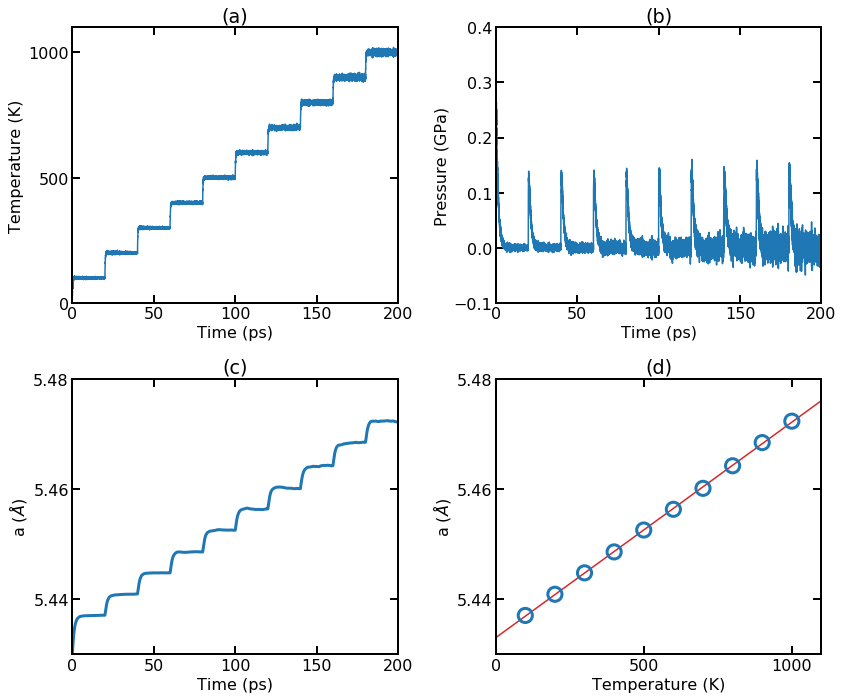

In [7]:
figure(figsize=(12,10))
subplot(2,2,1)
set_fig_properties([gca()])
plot(t, thermo['T'])
xlim([0, 200])
gca().set_xticks(range(0,201,50))
ylim([0, 1100])
gca().set_yticks(range(0,1101,500))
ylabel('Temperature (K)')
xlabel('Time (ps)')
title('(a)')

subplot(2,2,2)
set_fig_properties([gca()])
plot(t, Pave)
xlim([0, 200])
gca().set_xticks(range(0,201,50))
ylim([-0.1, 0.4])
gca().set_yticks(np.arange(-1,5)/10)
ylabel('Pressure (GPa)')
xlabel('Time (ps)')
title('(b)')

subplot(2,2,3)
set_fig_properties([gca()])
plot(t, a,linewidth=3)
xlim([0, 200])
gca().set_xticks(range(0,201,50))
ylim([5.43, 5.48])
gca().set_yticks([5.44,5.46,5.48])
ylabel(r'a ($\AA$)')
xlabel('Time (ps)')
title('(c)')

subplot(2,2,4)
set_fig_properties([gca()])
Tpoly = [0, 1100]
plot(Tpoly, fit(Tpoly),color='C3')
scatter(temp, a_ave,s=200,zorder=100,facecolor='none',edgecolors='C0',linewidths=3)
xlim([0, 1100])
gca().set_xticks(range(0,1101,500))
ylim([5.43, 5.48])
gca().set_yticks([5.44,5.46,5.48])
ylabel(r'a ($\AA$)')
xlabel('Temperature (K)')
title('(d)')

tight_layout()
show()

<b>(a)</b> Instant temperature as a function of simulation time. <b>(b)</b> Instant pressure as a function of simulation time. <b>(c)</b> Instant lattice constant as a function of simulation time. <b>(d)</b> Averaged lattice constant (over the last 10 ps in each run for a given temperature) as a function of temperature.

Additional figure notes:<br>
<ul>
<li>(a): The temperature for each run quickly reaches the target temperature (with fluctuations).</li>

<li>(b): The pressure (averaged over the three directions) for each run quickly reaches the target pressure zero (with fluctuations).</li>

<li>(c): The lattice constant (averaged over the three directions) for each run reaches a plateau (with fluctuations) after some steps.</li>

<li>(d): We calculate the average lattice constant at each temperature by averaging the second half of the data for each run. The average lattice constants at different temperatures can be well fit by a linear function, with the thermal expansion coefficient being estimated to be $\alpha \approx 7.2 \times 10^{-6} $ K<sup>-1</sup>.</li>
</ul>

<h1>4. <u>References</u></h1>
<ul>
<li>[Fan 2020] Zheyong Fan, Yanzhou Wang, Xiaokun Gu, Ping Qian, Yanjing Su, and Tapio Ala-Nissila, <a href="https://doi.org/10.1088/1361-648X/ab5c5f">A minimal Tersoff potential for diamond silicon with improved descriptions of elastic and phonon transport properties</a>, J. Phys.: Condens. Matter <b>32</b> 135901 (2020).</li>
</ul>    